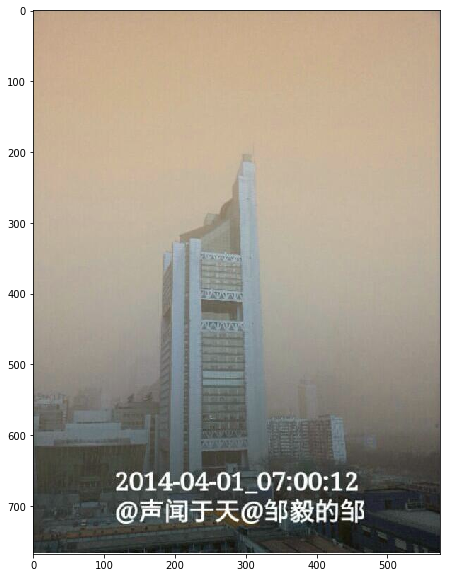

In [12]:
from __future__ import division
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

img_b = cv2.imread('2014_04_01_0700.jpg')
img_sh = cv2.imread('201412311145.jpg')
plt.imshow(img_b[:650, :])

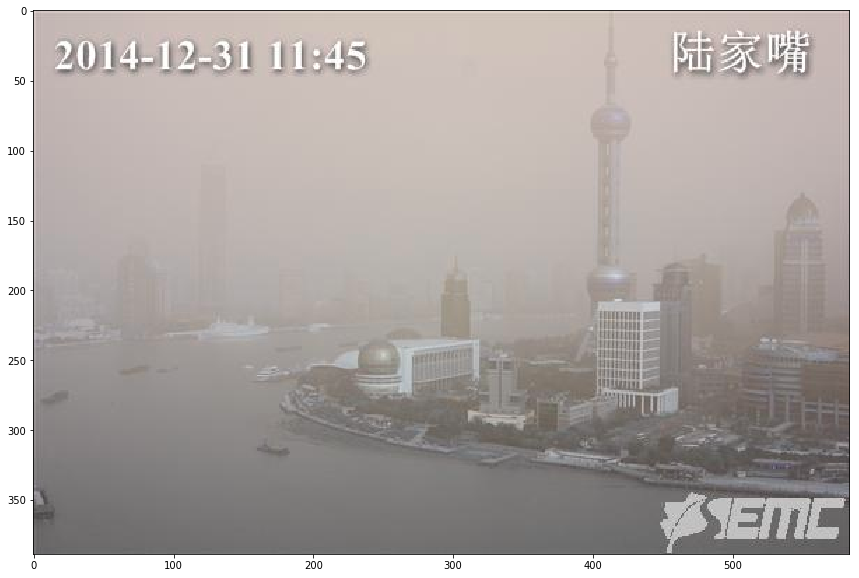

In [5]:
plt.imshow(img_sh[50:350, :])

In [17]:
import pandas as pd

data = pd.read_csv('../single_data.csv')
data.head()

,filename,datetime,dt_round,dt_round_2,ppm
0,Shanghai1/201407241115,201407241115,2014-07-24 11:15:00,2014-07-24 11:00:00,21.0
1,Shanghai1/201407271015,201407271015,2014-07-27 10:15:00,2014-07-27 10:00:00,49.0
2,Shanghai1/201407121315,201407121315,2014-07-12 13:15:00,2014-07-12 13:00:00,63.0
3,Shanghai1/201406171145,201406171145,2014-06-17 11:45:00,2014-06-17 12:00:00,35.0
4,Shanghai1/201407191415,201407191415,2014-07-19 14:15:00,2014-07-19 14:00:00,23.0


In [23]:
class Channel_value:
    val = -1.0
    intensity = -1.0

def find_intensity_of_atmospheric_light(img, gray):
    top_num = int(img.shape[0] * img.shape[1] * 0.001)
    toplist = [Channel_value()] * top_num
    dark_channel = find_dark_channel(img)

    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            val = img.item(y, x, dark_channel)
            intensity = gray.item(y, x)
            for t in toplist:
                if t.val < val or (t.val == val and t.intensity < intensity):
                    t.val = val
                    t.intensity = intensity
                    break

    max_channel = Channel_value()
    for t in toplist:
        if t.intensity > max_channel.intensity:
            max_channel = t

    return max_channel.intensity

def find_dark_channel(img):
    return np.unravel_index(np.argmin(img), img.shape)[2]

def stats_haze(img, light_intensity, windowSize, t0, w):
    size = (img.shape[0], img.shape[1])
    outimg = np.zeros(size, img.dtype)

    for y in range(size[0]):
        for x in range(size[1]):
            x_low = max(x-(windowSize//2), 0)
            y_low = max(y-(windowSize//2), 0)
            x_high = min(x+(windowSize//2), size[1])
            y_high = min(y+(windowSize//2), size[0])
            sliceimg = img[y_low:y_high, x_low:x_high]
            dark_channel = find_dark_channel(sliceimg)
            t = 1.0 - (w * img.item(y, x, dark_channel) / light_intensity)
            outimg.itemset((y,x), max(t,t0)*255)
    
    img_arr = np.ravel(outimg)
    
    per75 = np.percentile(img_arr,75)
    per50 = np.percentile(img_arr,50)
    permax = np.max(img_arr)
    per90 = np.percentile(img_arr,90)
    permean = np.average(img_arr)

    return per50,per75,per90,permean,permax

In [ ]:
from scipy.stats import spearmanr

pm = []
per50 = []
per75 = []
per90 = []
permean = []
permax = []

for index, row in data.iterrows():
    city = row['filename'][0]
    filename = '../'+row['filename']+'.jpg'
    if city == "B":
        img = cv2.imread(filename)[:650, :]
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        light_intensity = find_intensity_of_atmospheric_light(img, gray)
        w = 0.9
        t0 = 0.01
        a,b,c,d,e = stats_haze(img, light_intensity, 20, t0, w)
        per50.append(a)
        per75.append(b)
        per90.append(c)
        permean.append(d)
        permax.append(e)
        pm.append(float(row['ppm']))

print(spearmanr(pm,per50))
print(spearmanr(pm,per75))
print(spearmanr(pm,per90))
print(spearmanr(pm,permean))
print(spearmanr(pm,permax))